# 8. 수도권 아파트 가격 예측

- 빅데이터 수집 및 전처리 방법을 이해한다.
- 머신러닝 앙상블 알고리즘 중 XGBoost에 대해 이해한다.
- 랜덤 포레스트와 XGBoost 알고리즘으로 아파트 매매 가격 예측 인공지능 모델을 제작 및 비교한다.

#Kaggle 데이터 불러오기

➊ 데이터 세트를 제공하는 플랫폼인 캐글(kaggle)을 통해  오픈 API를 이용하여 데이터 불러오기

 캐글 홈페이지(www.kaggle.com)에 접속 -> 로그인 -> 오른쪽 상단의 프로필 ‘Your Profile’
-> Your Profile에 들어가 ‘Edit Public Profile’ 클릭 -> API 탭의 ‘Create New API Token’ 을 클릭  
-> ‘kaggle.json’을 다운로드


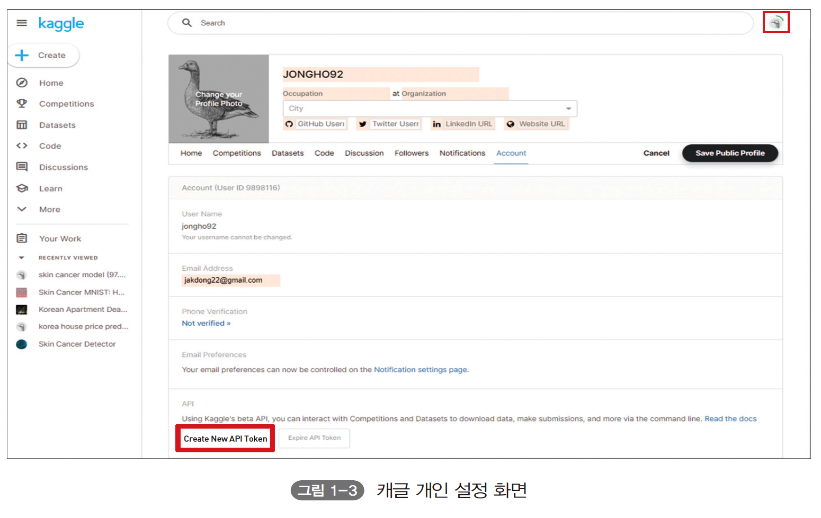

➋ 다음과 같이 캐글 모듈을 설치한 후 kaggle.json 파일을 업로드하고 해당 파일과 캐글을 연결하면 코랩과 캐글 사이트가 연동된다.

In [1]:
#kaggle 모듈 설치 및 json 파일 업로드
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jongho92","key":"970a42cb7650cfec7146834a2cb33e86"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

➌ 우리나라 아파트 거래 데이터를 가져오기
  - 캐글에서 ‘Korean Apartment Deal Data’를 검색한 후 오른쪽 상단 세로 3개 점 아이콘을
    클릭하여 API Command를 복사


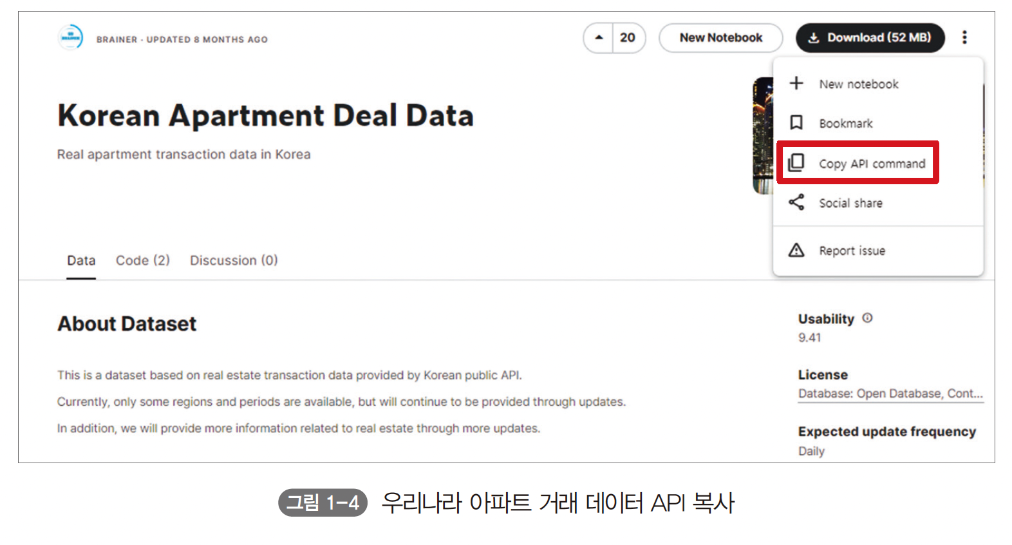

In [3]:
#한국 아파트 거래 가격 데이터 연결
!kaggle datasets download -d brainer3220/korean-real-estate-transaction-data
!unzip korean-real-estate-transaction-data
!ls

100% 59.0M/59.2M [00:04<00:00, 20.5MB/s]
100% 59.2M/59.2M [00:04<00:00, 12.6MB/s]
Archive:  korean-real-estate-transaction-data.zip
  inflating: Apart Deal.csv          
'Apart Deal.csv'   korean-real-estate-transaction-data.zip
 kaggle.json	   sample_data


➍ 우리나라 아파트 거래 데이터를 가져오기
  -  필요한 모듈을 가져오고 ‘Apart Deal.csv’ 파일을 판다스를 통해 불러온다.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
url ='/content/Apart Deal.csv'
df = pd.read_csv(url, delimiter=",")

<ipython-input-15-09b0aa2f67f8>:2: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, delimiter=",")


❺ 데이터 확인하기
 - 법정동, 거래일, 아파트 종류, 지번 등 9개의 속성으로 이루어진  총 434만 8,785개의 우리나라 아파트
거래 데이터를 확인할 수 있음

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5002839 entries, 0 to 5002838
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   지역코드    float64
 1   법정동     object 
 2   거래일     object 
 3   아파트     object 
 4   지번      object 
 5   전용면적    float64
 6   층       object 
 7   건축년도    float64
 8   거래금액    object 
dtypes: float64(3), object(6)
memory usage: 343.5+ MB


In [19]:
df.head()

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액
0,31110,학성동,5/30/2020 0:00,남운학성타운,379,135.5800,8,1991.0,26700
1,31110,남외동,1/3/2020 0:00,남외푸르지오1차,506-1,101.6000,2,2006.0,35500
2,31110,남외동,1/3/2020 0:00,에일린의뜰,500,84.9920,11,2007.0,36500
3,31110,남외동,1/3/2020 0:00,남외푸르지오1차,506-1,118.7060,8,2006.0,43000
4,31110,남외동,1/4/2020 0:00,남외푸르지오2차,501-1,84.9636,7,2007.0,38700


In [18]:
df['지역코드'] = df['지역코드'].astype(int)

##우리나라 아파트 거래 데이터 전처리하기

➊ 불필요한 내용 제거
- 데이터에서 ‘법정동’은 지역 코드로 구분 가능하고 ‘아파트’(아파트 이름)와 ‘지번’은 가격 예측에 불필요하다고 판단되어 모두 삭제
- 법정동 코드 다섯 자리로 나타낸 ‘지역’ 데이터를 앞의 두 자리와 나머지 뒤의 세 자리로 구분


In [20]:
#법정동은 지역코드로 구분가능
#아파트 이름과 지번은 가격 예측에 불필요
df = df.drop(['법정동', '아파트', '지번'], axis= 1)

In [21]:
#지역코드를 구분
#areacode는 시/도
#gecode는 군/읍/면/동/구
areacode= []
gecode = []
for code in df['지역코드'] :
  acode = str(code)[0:2]
  gcode = str(code)[2:]
  areacode.append(int(acode))
  gecode.append(int(gcode))
df['지역'] = gecode
df['지역코드'] = areacode

➋ 수도권 데이터 구성
- 서울특별시의 법정동 코드는 11, 경기도의 법정동 코드는 41
- 서울과 경기도 데이터만 가져오기

In [22]:
#서울시의 지역코드는 '11'
df2 = df[df['지역코드']==11]
#경기도의 지역코드는 '41'
df3 = df2[df2['지역코드'] == 41]

In [23]:
df = pd.concat([df2, df3])

In [24]:
df.head()

,지역코드,거래일,전용면적,층,건축년도,거래금액,지역
655312,11,1/13/2018,140.78,15,2004.0,130000,110
655313,11,1/19/2018,103.77,5,2003.0,96000,110
655314,11,1/23/2018,123.13,10,2004.0,118000,110
655315,11,1/30/2018,66.96,13,1994.0,54500,110
655316,11,1/31/2018,76.66,11,1994.0,64000,110


➌ ‘거래일' 데이터 형식 통일
- ‘거래일’의 데이터 형식을 모두 ‘20150000’ 형식으로 통일하고, 후에 카테고리 데이터로 설정하여 예측에 용이한 형태로 변환될 수 있도록 구성




In [25]:
import re

In [26]:
#날짜 형식 변경
#'1/31/2018'을 '20180118'로 변경
day = []
for date in df['거래일'] :
  date = date.split(' ')
  date = date[0]
  date = re.split('/|-', date)
  if len(date[0]) == 4 :
    date = int(date[0]+date[1]+date[2])
  else :
    if len(date[0]) == 1 :
      date[0] = '0'+date[0]
      if len(date[1]) == 1 :
        date[1] = '0'+date[1]
    date = int(date[2]+date[0]+date[1])
  day.append(date)
df['거래일']=day

In [27]:
df.tail()

,지역코드,거래일,전용면적,층,건축년도,거래금액,지역
4704692,11,20230416,49.82,7.0,2020.0,"60,000",740
4704693,11,20230420,84.83,5.0,2009.0,"86,000",740
4704694,11,20230421,84.53,8.0,2009.0,"85,000",740
4704695,11,20230422,84.53,8.0,2009.0,"84,000",740
4704696,11,20230422,49.82,7.0,2020.0,"61,000",740


➍ 거래 금액을 일반적인 숫자형 데이터로 변환
- 모두 문자형으로 변환한 후 replace( ) 함수로 ,(콤마)를 지우고 다시 숫자형으로 변환해 준다.
- 마지막으로 층의 Null 값을 0으로 채워 준다.


In [28]:
#거래금액 콤마(,) 제거
df['거래금액'] = df['거래금액'].astype('str')
df['거래금액'] = df['거래금액'].str.replace(',','')
df['거래금액'] = df['거래금액'].astype('int')

In [29]:
#층이 비어있으면 '0'을 넣어 결측치 제거
df['층'] = pd.to_numeric(df['층'], errors='coerce').fillna(0)

❺ 학습이 용이하도록 알맞은 형태로 변환

In [30]:
df['지역코드'] = df['지역코드'].astype('category')
df['지역'] = df['지역'].astype('category')
df['건축년도'] = df['건축년도'].astype('category')
df['거래일'] = df['거래일'].astype('category')
df['층'] = df['층'].astype('category')
df = df[['지역코드', '지역', '건축년도', '거래일', '층', '전용면적', '거래금액']]

In [31]:
df.sort_values(by=['지역'], axis=0)

,지역코드,지역,건축년도,거래일,층,전용면적,거래금액
655312,11,110,2004.0,20180113,15,140.78,130000
2823844,11,110,2008.0,20160907,1,84.92,50000
2823845,11,110,2004.0,20160910,13,111.73,65900
2823846,11,110,2014.0,20160912,11,12.78,12000
2823847,11,110,2004.0,20160917,18,84.95,56700
...,...,...,...,...,...,...,...
2279933,11,740,2002.0,20200113,11,84.43,60000
2279932,11,740,2004.0,20200111,5,84.97,59400
2279931,11,740,2019.0,20200111,27,59.11,94500
2279929,11,740,2019.0,20200111,18,49.68,91800


#랜덤 포레스트 모델 생성 및 학습하기


➊ 필요 모듈 라이브러리 불러오기

- 머신러닝 모델인 랜덤 포레스트(Random Forest)를 사이킷런(sklearn) 라이브러리에서 불러오기
데이터를 훈련 데이터와 테스트 데이터로 효과적으로 분리하기 위해 train_test_split 모듈을 불러오고, 모델의 학습 정도를 높이고 성능 평가를 위해 k-fold 모듈과 cross_validation(교차 검증), metrics(평가 척도) 모듈을 불러오고 랜덤 seed도 설정


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [33]:
seed = 0
np.random.seed(seed)
seed = tf.random.set_seed(3)

❷ 훈련 데이터와 테스트 데이터 나누기
- 지역 코드, 지역, 건축년도, 거래일, 층, 전용 면적 속성이 독립 변수이므로 X에 저장
거래 금액 속성이 종속 변수이므로 Y에 저장
실거래가 데이터를 모델이 학습할 수 있는 형태인 넘파이(Numpy) 배열로 변환
8:2로 분할하여 각각 훈련 데이터 세트, 테스트 데이터 세트로 나누기

In [34]:
dataset = df.values
X = dataset[:,0:6]
Y = dataset[:,6]

X = np.asarray(X)
Y = np.asarray(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

❸ k-fold 및 랜덤 포레스트 모델 구성
- 학습의 정확도를 높이기 위해서 k-fold 모듈을 사용하여 훈련 데이터 세트를 다시 다섯 개로 나누어서 다섯 번의 학습을 진행
- 각각의 학습에서 다섯 개 중 네 개의 데이터 세트를 train set, 나머지 한 개의 데이터 세트를 validation set로 구분
- 각각의 데이터 세트를 모두 네 번씩 학습


In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
forest = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs= -1)

❹ k-fold와 랜덤 포레스트 모델 학습
- k-fold를 적용하여 학습을 진행하면서, 각 학습마다 평가 척도로 validation set의 RMSE
(Root Mean Squared Error, 평균제곱근오차)와 R2를 출력





In [36]:
for train, test in kfold.split(X_train,Y_train) :
  print("TRAIN:", train, "TEST:", test)
  x_train, x_test = X_train[train], X_train[test]
  y_train, y_test = Y_train[train], Y_train[test]

  forest.fit(x_train, y_train)

  y_pred = forest.predict(x_test)

  print('validation split rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
  print('validation split R2 : {: .4f}'.format(metrics.r2_score(y_test, y_pred)))

TRAIN: [     0      1      2 ... 504255 504256 504257] TEST: [     5     12     13 ... 504236 504251 504252]
validation split rmse : 10340.4194
validation split R2 :  0.9604
TRAIN: [     0      1      3 ... 504254 504256 504257] TEST: [     2     11     17 ... 504214 504216 504255]
validation split rmse : 10300.5722
validation split R2 :  0.9616
TRAIN: [     1      2      3 ... 504255 504256 504257] TEST: [     0      6      8 ... 504239 504245 504249]
validation split rmse : 10441.8198
validation split R2 :  0.9607
TRAIN: [     0      1      2 ... 504252 504253 504255] TEST: [     3      7      9 ... 504254 504256 504257]
validation split rmse : 10641.2515
validation split R2 :  0.9595
TRAIN: [     0      2      3 ... 504255 504256 504257] TEST: [     1      4     21 ... 504242 504243 504253]
validation split rmse : 10719.8160
validation split R2 :  0.9580


- cross_validate 모듈을 이용하여 학습 후에 훈련 데이터가 학습이 잘 되었는지, 시간은 얼마나 걸렸는지를 확인

In [ ]:
cross_validate(forest, X_train, Y_train, cv = kfold,
               scoring= ['r2'],return_train_score = True )

❺ K-fold와 랜덤 포레스트 모델 학습 평가
- k-fold와 cross_validate로 랜덤 포레스트 모델의 학습과 평가를 마친 후, 테스트 데이터를 모델에 적용시켜 최종적으로 학습이 잘 되었는지 평가
- 마찬가지로 평가 척도는 RMSE와 R2를 사용하는데, 상대적인 평가가 가능한 평가 척도인 R2 결과가 0.95가 넘는 것으로 보아 학습이 잘 이루어졌음을 판단





In [ ]:
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, Y_test)))
pred = forest.predict(X_test)
print('rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(Y_test, pred))))
print('R2 : {:.4f}'.format(metrics.r2_score(Y_test, pred)))

테스트 세트 정확도: 0.953
rmse : 10593.0803
R2 : 0.9532


❻ 테스트 데이터로 가격 예측
- 마지막으로 학습을 거치지 않은 낯선 데이터는 테스트 데이터를 넣고 예측할 가격과 비교

In [ ]:
for i in range(0,20) :
  print('실제 아파트 가격 : %d만원, 예측 아파트 가격 : %d만원' %(Y_test[i], pred[i]))

실제 아파트 가격 : 88500만원, 예측 아파트 가격 : 95912만원
실제 아파트 가격 : 55000만원, 예측 아파트 가격 : 56958만원
실제 아파트 가격 : 35000만원, 예측 아파트 가격 : 33625만원
실제 아파트 가격 : 22000만원, 예측 아파트 가격 : 31501만원
실제 아파트 가격 : 41500만원, 예측 아파트 가격 : 39317만원
실제 아파트 가격 : 49000만원, 예측 아파트 가격 : 49869만원
실제 아파트 가격 : 21900만원, 예측 아파트 가격 : 23424만원
실제 아파트 가격 : 144000만원, 예측 아파트 가격 : 148124만원
실제 아파트 가격 : 26900만원, 예측 아파트 가격 : 28504만원
실제 아파트 가격 : 19300만원, 예측 아파트 가격 : 20253만원
실제 아파트 가격 : 33300만원, 예측 아파트 가격 : 36531만원
실제 아파트 가격 : 60000만원, 예측 아파트 가격 : 53756만원
실제 아파트 가격 : 62700만원, 예측 아파트 가격 : 47717만원
실제 아파트 가격 : 56000만원, 예측 아파트 가격 : 53762만원
실제 아파트 가격 : 32000만원, 예측 아파트 가격 : 34455만원
실제 아파트 가격 : 57000만원, 예측 아파트 가격 : 57975만원
실제 아파트 가격 : 51500만원, 예측 아파트 가격 : 48738만원
실제 아파트 가격 : 35500만원, 예측 아파트 가격 : 34882만원
실제 아파트 가격 : 69000만원, 예측 아파트 가격 : 73240만원
실제 아파트 가격 : 61800만원, 예측 아파트 가격 : 62677만원


#XGBoost 모델 생성 및 학습하기

➊ XGBoost 모델 설정
- 의사결정 트리 기반의 Boost 모델인 XGBoost 알고리즘으로 학습
- XGBoost는 자체 오픈 소스 라이브러리로 불러오기


In [ ]:
import xgboost
from xgboost import XGBRegressor

- k-fold를 적용하여 학습을 진행하고 XGBoost 모델을 구성
- XGBoost 모델은 랜덤 포레스트 알고리즘의 매개 변수와 동일하며 학습률(learning_rate)을 조절할 수 있는데, 여기서는 가장 일반적인 0.1로 설정

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
xgb = XGBRegressor(max_depth=20,learning_rate=0.1, n_estimators=100, n_jobs=-1)

➊ XGBoost 모델 설정

In [ ]:
for train, test in kfold.split(X_train,Y_train) :
  print("TRAIN:", train, "TEST:", test)
  x_train, x_test = X_train[train], X_train[test]
  y_train, y_test = Y_train[train], Y_train[test]

  xgb.fit(x_train, y_train)

  y_pred2 = xgb.predict(x_test)

  print('validation split rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred2))))
  print('validation split R2 : {: .4f}'.format(metrics.r2_score(y_test, y_pred2)))

TRAIN: [     0      1      2 ... 473652 473653 473654] TEST: [     9     13     16 ... 473647 473648 473651]
[04:42:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
validation split rmse : 9290.1602
validation split R2 :  0.9633
TRAIN: [     0      1      2 ... 473651 473652 473654] TEST: [     6      7     11 ... 473646 473649 473653]
[04:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
validation split rmse : 9352.6804
validation split R2 :  0.9637
TRAIN: [     0      2      3 ... 473650 473651 473653] TEST: [     1      4      8 ... 473644 473652 473654]
[04:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
validation split rmse : 9175.4502
validation split R2 :  0.9646
TRAIN: [     1      4      5 ... 473652 473653 473654] TEST: [     0      2      3 ... 473641 473643

❷ XGBoost 모델 학습




In [ ]:
cross_validate(xgb, X_train, Y_train, cv = kfold, scoring= ['r2'],return_train_score = True )

[04:45:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'fit_time': array([33.40692806, 34.34074402, 31.64368486, 32.79911041, 31.97617483]),
 'score_time': array([0.55166888, 0.54781389, 0.58206487, 0.54637671, 0.55021572]),
 'test_r2': array([0.96337913, 0.96397843, 0.96358009, 0.96189989, 0.96216968]),
 'train_r2': array([0.99844807, 0.99845082, 0.9985999 , 0.9984245 , 0.99852631])}

In [ ]:
print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test, Y_test)))
pred2 = xgb.predict(X_test)
print('rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(Y_test, pred2))))
print('R2 : {:.4f}'.format(metrics.r2_score(Y_test, pred2)))

테스트 세트 정확도: 0.962
rmse : 9558.1632
R2 : 0.9619


❸ XGBoost 모델 테스트
- 테스트 데이터로 평가하고 20개의 가격을 예측

In [ ]:
for i in range(0,20) :
  print('실제 아파트 가격 : %d만원, 예측 아파트 가격 : %d만원' %(Y_test[i], pred2[i]))

실제 아파트 가격 : 88500만원, 예측 아파트 가격 : 94866만원
실제 아파트 가격 : 55000만원, 예측 아파트 가격 : 56978만원
실제 아파트 가격 : 35000만원, 예측 아파트 가격 : 34616만원
실제 아파트 가격 : 22000만원, 예측 아파트 가격 : 34360만원
실제 아파트 가격 : 41500만원, 예측 아파트 가격 : 36545만원
실제 아파트 가격 : 49000만원, 예측 아파트 가격 : 49992만원
실제 아파트 가격 : 21900만원, 예측 아파트 가격 : 21520만원
실제 아파트 가격 : 144000만원, 예측 아파트 가격 : 162527만원
실제 아파트 가격 : 26900만원, 예측 아파트 가격 : 27163만원
실제 아파트 가격 : 19300만원, 예측 아파트 가격 : 21650만원
실제 아파트 가격 : 33300만원, 예측 아파트 가격 : 38265만원
실제 아파트 가격 : 60000만원, 예측 아파트 가격 : 55327만원
실제 아파트 가격 : 62700만원, 예측 아파트 가격 : 56535만원
실제 아파트 가격 : 56000만원, 예측 아파트 가격 : 53874만원
실제 아파트 가격 : 32000만원, 예측 아파트 가격 : 34298만원
실제 아파트 가격 : 57000만원, 예측 아파트 가격 : 57309만원
실제 아파트 가격 : 51500만원, 예측 아파트 가격 : 47374만원
실제 아파트 가격 : 35500만원, 예측 아파트 가격 : 35208만원
실제 아파트 가격 : 69000만원, 예측 아파트 가격 : 69142만원
실제 아파트 가격 : 61800만원, 예측 아파트 가격 : 62921만원


❹ 랜덤 포레스트와 XGBoost 모델 비교 시각화

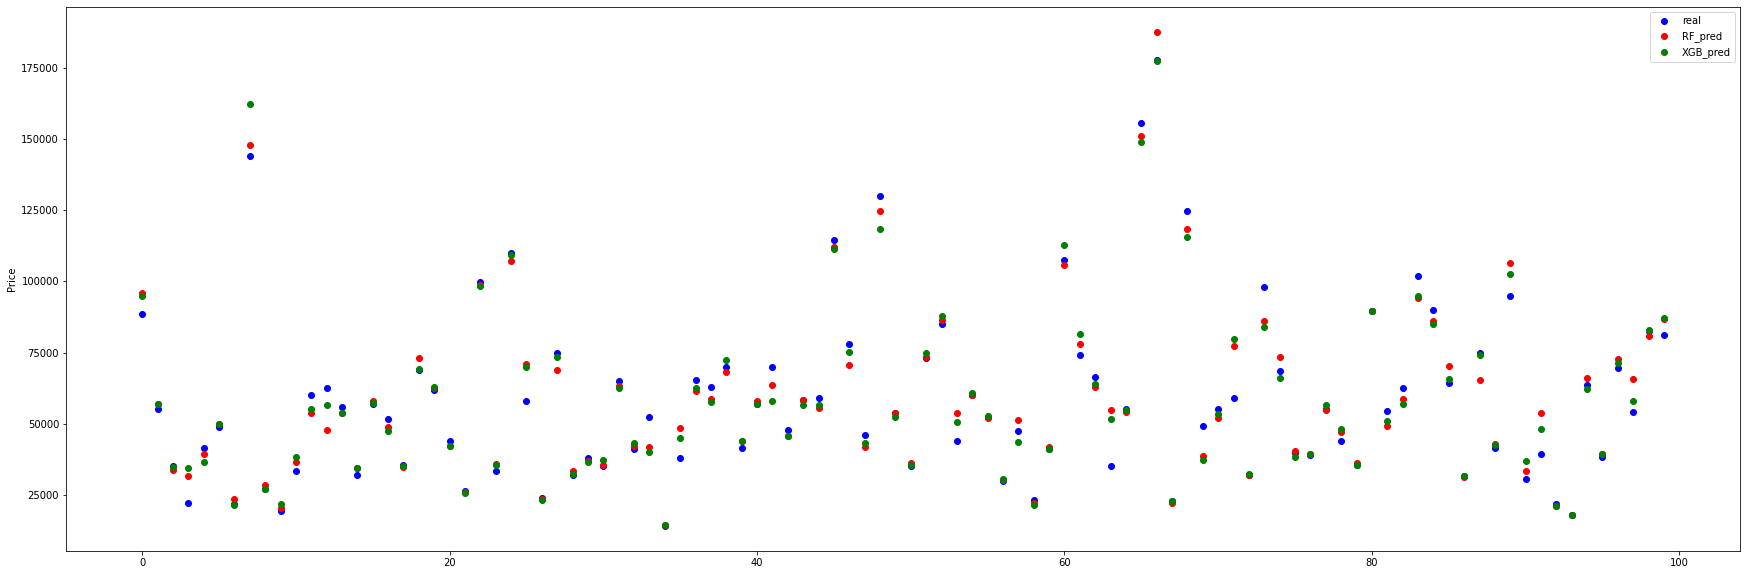

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(Y_test[0:100],'bo', label='real')
plt.plot(pred[0:100],'ro', label='RF_pred')
plt.plot(pred2[0:100],'go', label='XGB_pred')
plt.ylabel('Price')
plt.legend()
plt.show()

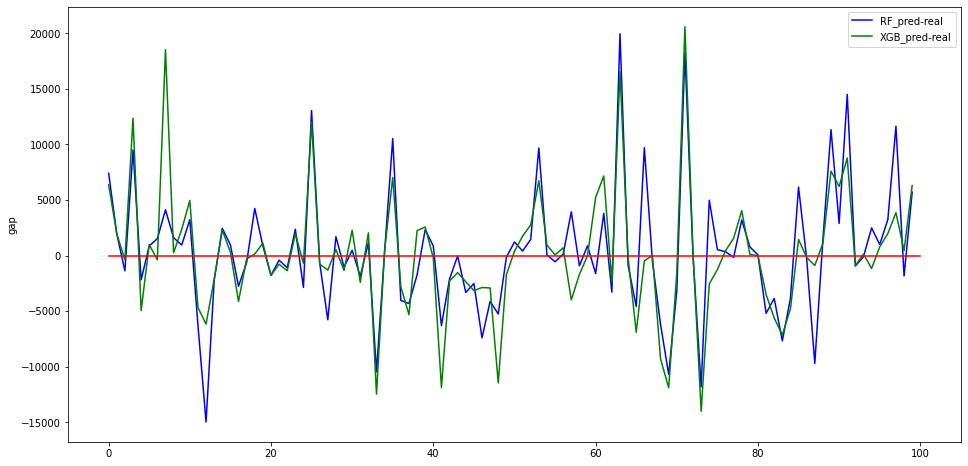

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(pred[0:100]-Y_test[0:100],'b-', label='RF_pred-real')
plt.plot(pred2[0:100]-Y_test[0:100], 'g-', label='XGB_pred-real')
plt.plot([0,100],[0,0],'r-')
plt.ylabel('gap')
plt.legend()
plt.show()